**Exercise 1**

In [21]:
annotations_dir = "BCCD_Annot/Annotations"
images_dir = "BCCD_Annot/JPEGImages"

In [22]:
IMG_SIZE = (128, 128)  
BATCH_SIZE = 32

def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    labels = []
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    return boxes, labels

def load_data(images_path, annotations_path):
    images = []
    labels = []
    label_map = {'WBC': 0, 'RBC': 1, 'Platelets': 2}  
    for image_file in os.listdir(images_path):
        img = cv2.imread(os.path.join(images_path, image_file))
        img = cv2.resize(img, IMG_SIZE)
        images.append(img)
    
        xml_file = os.path.join(annotations_path, image_file.replace('.jpg', '.xml'))
        if os.path.exists(xml_file):
            _, file_labels = parse_xml(xml_file)
            labels.append(label_map[file_labels[0]])  
    return np.array(images), np.array(labels)

https://www.kaggle.com/datasets/ammarnassanalhajali/bccd-coco/data

In [23]:
images, labels = load_data(images_dir, annotations_dir)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Number of training images: 291
Number of testing images: 73


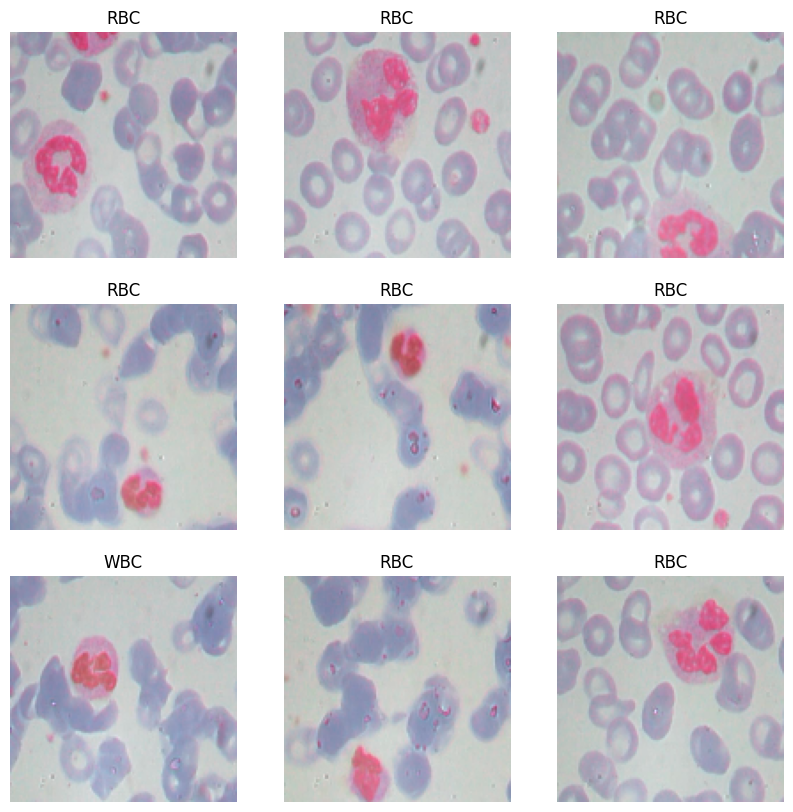

In [24]:
def plot_images(images, labels, class_names):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()

class_names = ['WBC', 'RBC', 'Platelets']
plot_images(train_images, train_labels, class_names)

In [25]:
datagen = ImageDataGenerator(
    rescale=1./255,      
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

In [26]:
train_augmented = datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE)
test_augmented = datagen.flow(test_images, test_labels, batch_size=BATCH_SIZE)

print(f"Number of augmented training images: {len(train_augmented) * BATCH_SIZE}")
print(f"Number of augmented testing images: {len(test_augmented) * BATCH_SIZE}")


Number of augmented training images: 320
Number of augmented testing images: 96


In [27]:
def create_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(3, activation='softmax')  # 3 classes: WBC, RBC, Platelets
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [28]:
model_without_aug = create_cnn_model()
history_without_aug = model_without_aug.fit(train_images / 255.0, train_labels, epochs=10, validation_data=(test_images / 255.0, test_labels))

C:\Users\sselc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 230ms/step - accuracy: 0.6471 - loss: 0.7526 - val_accuracy: 0.7671 - val_loss: 0.6592
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.8323 - loss: 0.6049 - val_accuracy: 0.7671 - val_loss: 0.6681
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step - accuracy: 0.8600 - loss: 0.4663 - val_accuracy: 0.7671 - val_loss: 0.6333
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8230 - loss: 0.5592 - val_accuracy: 0.7671 - val_loss: 0.6860
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8176 - loss: 0.5835 - val_accuracy: 0.7671 - val_loss: 0.7337
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step - accuracy: 0.8264 - loss: 0.5633 - val_accuracy: 0.7671 - val_loss: 0.6338
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.8444 - loss: 0.5074 - val_accuracy: 0.7671 - val_loss: 0.6450
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.8282 - loss: 0.5566 - val_accuracy: 0.

In [29]:
print("\nTraining and Testing Accuracy without Augmentation:")
train_accuracy_no_aug = history_without_aug.history['accuracy'][-1]
test_accuracy_no_aug = history_without_aug.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy_no_aug}")
print(f"Testing Accuracy: {test_accuracy_no_aug}")


Training and Testing Accuracy without Augmentation:
Training Accuracy: 0.838487982749939
Testing Accuracy: 0.767123281955719


In [30]:
model_with_aug = create_cnn_model()
history_with_aug = model_with_aug.fit(train_augmented, epochs=10, validation_data=test_augmented)

C:\Users\sselc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 323ms/step - accuracy: 0.6589 - loss: 0.7127 - val_accuracy: 0.7671 - val_loss: 0.8181
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.8407 - loss: 0.5736 - val_accuracy: 0.7671 - val_loss: 0.6552
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 255ms/step - accuracy: 0.8146 - loss: 0.5899 - val_accuracy: 0.7671 - val_loss: 0.6969
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 284ms/step - accuracy: 0.8537 - loss: 0.5383 - val_accuracy: 0.7671 - val_loss: 0.6497
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.8012 - loss: 0.6286 - val_accuracy: 0.7671 - val_loss: 0.8044
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 266ms/step - accuracy: 0.8547 - loss: 0.5024 - val_accuracy: 0.7671 - val_loss: 0.6646
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step - accuracy: 0.8305 - loss: 0.5770 - val_accuracy: 0.7671 - val_loss: 0.8766
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.8427 - loss: 0.5557 - val_accuracy: 0.

In [31]:
print("\nTraining and Testing Accuracy with Augmentation:")
train_accuracy_aug = history_with_aug.history['accuracy'][-1]
test_accuracy_aug = history_with_aug.history['val_accuracy'][-1]
print(f"Training Accuracy: {train_accuracy_aug}")
print(f"Testing Accuracy: {test_accuracy_aug}")


Training and Testing Accuracy with Augmentation:
Training Accuracy: 0.8350515365600586
Testing Accuracy: 0.767123281955719


In [32]:
print("\nComparison of Training and Testing Accuracy:")
print(f"Training Accuracy without Augmentation: {train_accuracy_no_aug}")
print(f"Testing Accuracy without Augmentation: {test_accuracy_no_aug}")
print(f"Training Accuracy with Augmentation: {train_accuracy_aug}")
print(f"Testing Accuracy with Augmentation: {test_accuracy_aug}")


Comparison of Training and Testing Accuracy:
Training Accuracy without Augmentation: 0.838487982749939
Testing Accuracy without Augmentation: 0.767123281955719
Training Accuracy with Augmentation: 0.8350515365600586
Testing Accuracy with Augmentation: 0.767123281955719


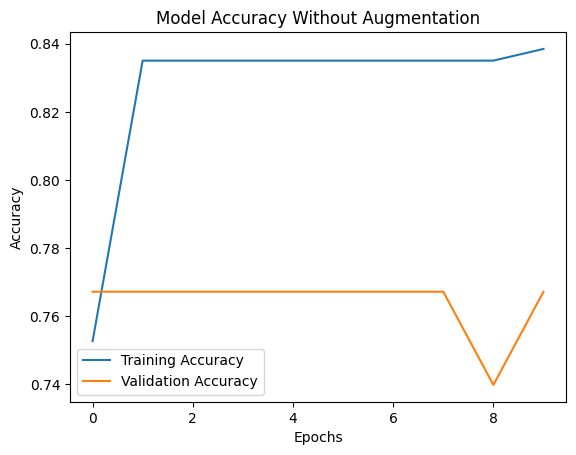

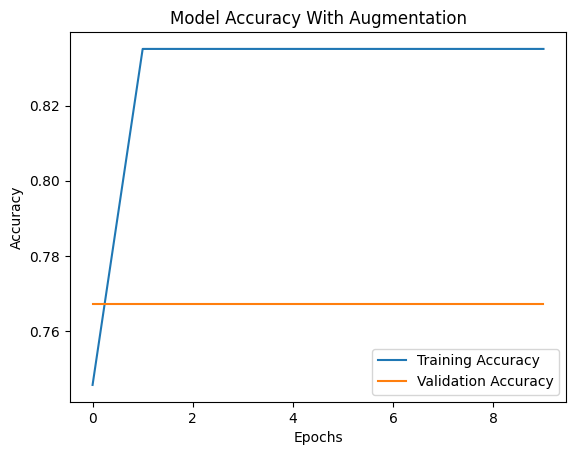

In [33]:
import matplotlib.pyplot as plt

def plot_accuracy(history, title):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(history_without_aug, "Model Accuracy Without Augmentation")

plot_accuracy(history_with_aug, "Model Accuracy With Augmentation")